In [1]:
#Run cell to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# install package to have access to custom functions
%pip install /content/drive/MyDrive/limb_position_EMG/ --use-feature=in-tree-build

Processing ./drive/MyDrive/limb_position_EMG
  Created wheel for limb-position-EMG: filename=limb_position_EMG-0.1.0-py3-none-any.whl size=18731 sha256=cbd6e63761cb822d6ea38292e2401c9dc69a486751ab7df9761a606e302d09f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-npmx74th/wheels/19/1f/9c/02f578de9f15a46a946d8518e4301d1e276944319c595a5e75
Successfully built limb-position-EMG
  Attempting uninstall: limb-position-EMG
    Found existing installation: limb-position-EMG 0.1.0
    Uninstalling limb-position-EMG-0.1.0:
      Successfully uninstalled limb-position-EMG-0.1.0


In [6]:
!cd /content/drive/MyDrive/limb_position_EMG/
!pwd

/content


In [6]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import sys
import h5py

#import cusotm functions
from limb_position_EMG.utils import *
from limb_position_EMG.analysis import log_reg_xsubject_transform_module_train_frac_subjects, log_reg_xsubject_transform_module_train_all_subjects


In [5]:
#define where the data files are located
data_folder = '/content/drive/MyDrive/limb_position_EMG/EMG_data/'

nsubjects = 36

#randomly-selected subjects to use as hold-out test data 
test_subjects = [17, 23,  7,  8,  3]

# User-defined parameters
lo_freq = 20 #lower bound of bandpass filter
hi_freq = 450 #upper bound of bandpass filter

win_size = 100 #define window size over which to compute time-domain features
step = win_size #keeping this parameter in case we want to re-run later with some overlap



In [6]:
#intialize empty lists
feature_matrix_all = np.empty((0,0))
target_labels_all = np.empty((0,))
window_tstamps_all = np.empty((0,))
block_labels_all  = np.empty((0,))
series_labels_all  = np.empty((0,))
subject_id_all = np.empty((0,))
block_count = 0

for subject_id in range(1,nsubjects+1):
    if subject_id not in test_subjects:
        subject_folder = os.path.join(data_folder,'%02d'%(subject_id))
        print('=======================')
        print(subject_folder)

        # Process data and get features 
        #get features across segments and corresponding info
        feature_matrix, target_labels, window_tstamps, \
        block_labels, series_labels = get_subject_data_for_classification(subject_folder, lo_freq, hi_freq, \
                                                                        win_size, step)

        #prevent repeat of block labels by increasing block count
        block_labels = block_labels+block_count
        block_count = np.max([block_count, np.max(block_labels)])


        # concatenate lists
        feature_matrix_all = np.vstack((feature_matrix_all,feature_matrix)) if feature_matrix_all.size else feature_matrix
        target_labels_all = np.hstack((target_labels_all,target_labels))
        window_tstamps_all = np.hstack((window_tstamps_all,window_tstamps))
        block_labels_all = np.hstack((block_labels_all,block_labels))
        series_labels_all = np.hstack((series_labels_all,series_labels))
        subject_id_all = np.hstack((subject_id_all,np.ones((block_labels.size))*subject_id))
        

/content/drive/MyDrive/limb-position-EMG/EMG_data/01
/content/drive/MyDrive/limb-position-EMG/EMG_data/02
/content/drive/MyDrive/limb-position-EMG/EMG_data/04
/content/drive/MyDrive/limb-position-EMG/EMG_data/05
/content/drive/MyDrive/limb-position-EMG/EMG_data/06
/content/drive/MyDrive/limb-position-EMG/EMG_data/09
/content/drive/MyDrive/limb-position-EMG/EMG_data/10
/content/drive/MyDrive/limb-position-EMG/EMG_data/11
/content/drive/MyDrive/limb-position-EMG/EMG_data/12
/content/drive/MyDrive/limb-position-EMG/EMG_data/13
/content/drive/MyDrive/limb-position-EMG/EMG_data/14
/content/drive/MyDrive/limb-position-EMG/EMG_data/15
/content/drive/MyDrive/limb-position-EMG/EMG_data/16
/content/drive/MyDrive/limb-position-EMG/EMG_data/18
/content/drive/MyDrive/limb-position-EMG/EMG_data/19
/content/drive/MyDrive/limb-position-EMG/EMG_data/20
/content/drive/MyDrive/limb-position-EMG/EMG_data/21
/content/drive/MyDrive/limb-position-EMG/EMG_data/22
/content/drive/MyDrive/limb-position-EMG/EMG_d

In [7]:
#define hyper params for each model
model_dict = {1:{'n_dense_pre':1, 'activation':'linear'},\
              2:{'n_dense_pre':1, 'activation':'tanh'},\
              3:{'n_dense_pre':1, 'activation':'relu'},\
              4:{'n_dense_pre':2, 'activation':'tanh'},\
              5:{'n_dense_pre':2, 'activation':'relu'},\
              6:{'n_dense_pre':3, 'activation':'tanh'},\
              7:{'n_dense_pre':3, 'activation':'relu'},\
}

In [71]:
#network training args 
verbose = 0
epochs = 30
batch_size = 5

#validation scheme args
n_train_splits = 4
n_val_splits = 2
nreps = 1

#excluded labels
exclude = [0,7]


results_folder = '/content/drive/MyDrive/limb-position-EMG-Repo/results_data/xsubject_transform_module/log_reg/'

model_id = 1
results_model_df = []
np.random.seed(1)#to replicate results
for rep in range(nreps):

    print('Model %i || Rep %02d'%(model_id, rep+1))
    print('----True Data----')
    rep_results_df = log_reg_xsubject_transform_module_train_frac_subjects(feature_matrix_all, target_labels_all, subject_id_all, block_labels_all,\
                                                    series_labels_all, exclude, model_dict[model_id],\
                                                    n_train_splits = n_train_splits,n_val_splits = n_val_splits,\
                                                    verbose = verbose, epochs = epochs, batch_size = batch_size, permute = False)
    # add details and concatenate dataframe
    rep_results_df['Shuffled'] = False
    rep_results_df = rep_results_df.rename(columns={'Rep':'Rep_subject_order'})
    rep_results_df['Rep_all'] =  rep+1
    rep_results_df['Model'] = model_id
    results_model_df.append(rep_results_df)

    print('Model %i || Rep %02d'%(model_id, rep+1))
    print('----Permuted Data----')
    rep_results_df = log_reg_xsubject_transform_module_train_frac_subjects(feature_matrix_all, target_labels_all, subject_id_all, block_labels_all,\
                                                    series_labels_all, exclude, model_dict[model_id],\
                                                    n_train_splits = n_train_splits,n_val_splits = n_val_splits,\
                                                    verbose = verbose, epochs = epochs, batch_size = batch_size, permute = True)
    # add details and concatenate dataframe
    rep_results_df['Shuffled'] = True
    rep_results_df = rep_results_df.rename(columns={'Rep':'Rep_subject_order'})
    rep_results_df['Rep_all'] =  rep+1
    rep_results_df['Model'] = model_id
    results_model_df.append(rep_results_df)

results_model_df = pd.concat(results_model_df,axis = 0)
# #save results to file
# results_fn = 'model_%02d_results.h5'%(model_id)
# results_model_df.to_hdf(os.path.join(results_folder,results_fn), key='results_df', mode='w')

Model 1 || Rep 01
----True Data----
-------Split Count: 1-------
Training: Subject 01 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 02 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 03 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 04 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 05 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 06 out of 06
Training Model
Evaluate Model on Trained Data
Validation: Subject 01 out of 02
Validation: Subject 02 out of 02
-------Split Count: 2-------
Training: Subject 01 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 02 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 03 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 04 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 05 out of 06
Training Model
Evaluate Model on Traine

In [72]:
results_model_df.groupby(['Shuffled','Type']).mean()

F1_score  Subject  Fold  Rep_all  Model
Shuffled Type                                              
False    Train      0.971714      7.0   2.5      1.0    1.0
         Val_Test   0.931618      7.0   2.5      1.0    1.0
         Val_Train  0.975141      7.0   2.5      1.0    1.0
True     Train      0.415147      7.0   2.5      1.0    1.0
         Val_Test   0.084788      7.0   2.5      1.0    1.0
         Val_Train  0.227682      7.0   2.5      1.0    1.0

In [ ]:
results_folder = '/content/drive/MyDrive/limb-position-EMG/results_data/xsubject_transform_module/log_reg/'
model_dir = '/content/drive/MyDrive/limb-position-EMG/model_data/xsubject_transform_module/log_reg/'
figure_dir = '/content/drive/MyDrive/limb-position-EMG/figures/training_history/xsubject_transform_module/log_reg/'


#network training args 
verbose = 0
epochs = 30
batch_size = 2
nreps = 10

#use first series to train (let it be input)
# train_idxs = np.where(series_labels_all==0)[0]
# test_idxs = np.where(series_labels_all==1)[0]

train_idxs = np.where(series_labels_all>=0)[0]
test_idxs = np.array([])
exclude = [0,7]

model_id = 1
results_model_df = []
np.random.seed(1)
for rep in range(nreps):

    print('Model %i || Rep %02d'%(model_id, rep+1))
    print('----True Data----')
    figure_folder = os.path.join(figure_dir,'rep_%i'%(rep+1))
    if not os.path.isdir(figure_folder):
        os.makedirs(figure_folder)
    model_folder = os.path.join(model_dir,'rep_%i'%(rep+1))
    if not os.path.isdir(model_folder):
        os.makedirs(model_folder)

    results_df, scaler = log_reg_xsubject_transform_module_train_all_subjects(feature_matrix_all, target_labels_all, subject_id_all, block_labels_all,\
                                                            train_idxs, test_idxs, exclude, model_dict[model_id],\
                                                            figure_folder = figure_folder, model_folder = model_folder,\
                                                            verbose = verbose, epochs = epochs, batch_size = batch_size,\
                                                            permute = False)
    #fill in details and append to list
    results_df['Shuffled'] = False
    results_df['Rep'] = rep+1
    results_model_df.append(results_df)

    print('Model %i || Rep %02d'%(model_id, rep+1))
    print('----Permuted Data----')
    results_df, scaler = log_reg_xsubject_transform_module_train_all_subjects(feature_matrix_all, target_labels_all, subject_id_all, block_labels_all,\
                                                            train_idxs, test_idxs, exclude, model_dict[model_id],\
                                                            figure_folder = figure_folder, model_folder = model_folder,\
                                                            verbose = verbose, epochs = epochs, batch_size = batch_size,\
                                                            permute = True)
    #fill in details and append to list
    results_df['Shuffled'] = True
    results_df['Rep'] = rep+1
    results_model_df.append(results_df)
results_model_df = pd.concat(results_model_df,axis = 0)

#save results to file
results_fn = 'train_model_transform_module_all_training_data_results.h5'
results_model_df.to_hdf(os.path.join(results_folder,results_fn), key='results_df', mode='w')

#save scaler
scaler_fn = 'trained_scaler_all_training_data.pkl'
with open(os.path.join(model_dir,scaler_fn), "wb") as output_file:
    pickle.dump(scaler, output_file)

Model 1 || Rep 01
----True Data----
Training: Subject 01 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 02 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 03 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 04 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 05 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 06 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 07 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 08 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 09 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 10 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 11 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 12 out of 31
Training Model
Evaluate Model on Trained Data
Training: Subject 13 out of 31
Training 

NameError: ignored

In [13]:
results_model_df.groupby(['Shuffled','Type']).mean()

,,F1_score,Subject,Rep
Shuffled,Type,,,
False,Train,0.954301,1.5,1
True,Train,0.705780,1.5,1


In [11]:
results_model_df

,F1_score,Subject,Type,Shuffled,Rep
0,0.932416,1.0,Train,False,1
1,0.985570,2.0,Train,False,1
0,0.836803,1.0,Train_val,False,1
1,0.956876,2.0,Train_val,False,1
0,0.676244,2.0,Train,True,1
1,0.658952,1.0,Train,True,1
0,0.114029,2.0,Train_val,True,1
1,0.029538,1.0,Train_val,True,1


In [67]:
# model_dir = '/content/drive/MyDrive/limb-position-EMG-Repo/model_data/xsubject_transform_module/log_reg/'
# figure_dir = '/content/drive/MyDrive/limb-position-EMG-Repo/figures/training_history/xsubject_transform_module/log_reg/'

# rep = 0
# figure_folder = os.path.join(figure_dir,'rep_%i'%(rep+1))
# if not os.path.isdir(figure_folder):
#     os.makedirs(figure_folder)
# model_folder = os.path.join(model_dir,'rep_%i'%(rep+1))
# if not os.path.isdir(model_folder):
#     os.makedirs(model_folder)

feature_matrix = feature_matrix_all.copy()
target_labels = target_labels_all.copy()
sub_labels = subject_id_all.copy()
block_labels = block_labels_all.copy()
series_labels = series_labels_all.copy()


n_train_splits = 4
n_val_splits = 2

verbose = 0
epochs = 30
batch_size = 5
mv = None
permute = True
exclude = [0,7]

-------Split Count: 1-------
Training: Subject 01 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 02 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 03 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 04 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 05 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 06 out of 06
Training Model
Evaluate Model on Trained Data
Validation: Subject 01 out of 02
Validation: Subject 02 out of 02
-------Split Count: 2-------
Training: Subject 01 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 02 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 03 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 04 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 05 out of 06
Training Model
Evaluate Model on Trained Data
Training: Subject 06 out of 0

In [69]:
results_df.groupby('Type').mean()

,F1_score,Subject,Fold
Type,,,
Train,0.491632,7.0,2.5
Val_Test,0.054373,7.0,2.5
Val_Train,0.259183,7.0,2.5


In [62]:
results_df.groupby('Type').mean()

,F1_score,Subject,Fold
Type,,,
Train,0.971552,7.0,2.5
Val_Test,0.926964,7.0,2.5
Val_Train,0.976505,7.0,2.5


In [44]:
pd.concat(results_df,axis = 0)

,F1_score,Subject,Fold,Type
0,0.992348,6.0,1,Train
1,6.000000,12.0,1,Train
2,1.000000,7.0,1,Train
3,2.000000,11.0,1,Train
4,10.000000,3.0,1,Train
5,4.000000,10.0,1,Train
0,0.992348,6.0,1,Train
1,1.000000,12.0,1,Train
2,1.000000,7.0,1,Train
3,2.000000,11.0,1,Train


In [27]:
# def log_reg_xsubject_transform_module_train_val_subjects(feature_matrix, target_labels, sub_labels, block_labels,
#                                                 save_training_plot = False, figure_folder = '',\
#                                                 save_model = False, model_folder = '',\
#                                                          model_dict,n_train_splits = 4, n_val_splits = 2,\
#                                                          verbose = 0, epochs = 40, batch_size = 2, mv = None, permute = False):
#     """

#     """

results_df = []

subs = np.unique(sub_labels)

if permute:
    #permute while ignoring excluded blocks
    target_labels = permute_class_within_sub(target_labels, block_labels, sub_labels, exclude)


#get training data cubes
X_train_cube, Y_train_cube, scaler = prepare_data_for_log_reg(feature_matrix, target_labels, train_idxs, exclude, train = True)
in_samples = np.where(np.isin(target_labels,exclude, invert = True))[0]
sub_labels_train = sub_labels[np.intersect1d(train_idxs,in_samples)]

#test for equal number of samples
assert X_train_cube.shape[0] == Y_train_cube.shape[0]
n_features, n_outputs = X_train_cube.shape[1], Y_train_cube.shape[1]

if test_idxs.size>0:
    #get testing data cubes
    X_test_cube, Y_test_cube, scaler = prepare_data_for_log_reg(feature_matrix, target_labels, test_idxs, exclude, train = False, scaler = scaler)
    in_samples = np.where(np.isin(target_labels,exclude, invert = True))[0]
    sub_labels_test = sub_labels[np.intersect1d(test_idxs,in_samples)]

# permute order in which subjects' data is used for training
subs_perm = np.random.permutation(subs)


#initialize empty list
train_f1_scores = np.empty((subs.size))
test_f1_scores = np.empty((subs.size))

# --- Training Stage ---
# Define model architecture

#setting timestep dimension to None 
model = get_log_reg_model((n_features,),n_outputs, n_dense_pre=model_dict[1]['n_dense_pre'], activation=model_dict[1]['activation'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary
# # Get transform module template
transform_module_template = get_transform_module(model, Input(shape = (None,n_features)),1)


# iterate thorugh subjects' data
for sub_idx, train_sub in enumerate(subs_perm):
    print('Training: Subject %02d out of %02d'%(sub_idx+1, subs_perm.size))
    # get subject-specific samples
    train_sub_idxs = np.where(sub_labels_train == train_sub)[0]

    X_cube_sub = X_train_cube[train_sub_idxs,:]
    Y_cube_sub = Y_train_cube[train_sub_idxs,]
    # initialize weights of the transform module
    model = tm_template_weights_to_model(transform_module_template, model)

    print('Training Model')
    # fit network
    history = model.fit(X_cube_sub, Y_cube_sub, epochs=epochs, batch_size=batch_size, verbose=verbose)
    if figure_folder:
        #plot training loss
        fig_title = 'Subject %02d'%(train_sub)
        fig_fn = os.path.join(figure_folder,'log_reg_model_subject_%02d_all_train_data_permuted_%s_loss.png'%(train_sub,str(permute)))
        plot_train_loss(history, fig_title, fig_fn)

    #copy weights to a transfer module template, save if wanted
    trained_transfer_module = model_weights_to_tm_template(transform_module_template, model)
    if model_folder:
        #save trained transfer module to file
        model_fn = os.path.join(model_folder, 'transform_module_subject_%02d_all_train_data_permuted_%s.h5'%(train_sub, str(permute)))
        keras.models.save_model(trained_transfer_module, model_fn, save_format= 'h5')
    # # evaluate trained network
    print('Evaluate Model on Trained Data')

    if mv:
        # get f1 score after applying majority voting scheme to model predictions
        train_f1_scores[sub_idx]  = apply_mv_and_get_f1_score(feature_matrix, target_labels,\
                                                              np.intersect1d(np.where(sub_labels==train_sub)[0],train_idxs), exclude,\
                                                              scaler, model, mv)
        if test_idxs.size>0:
            test_f1_scores[sub_idx] = apply_mv_and_get_f1_score(feature_matrix, target_labels, \
                                                                np.intersect1d(np.where(sub_labels==train_sub)[0],test_idxs), exclude,\
                                                                scaler, model, mv)

    else:
        #get score for training data
        train_f1_scores[sub_idx]  = get_log_reg_f1(X_cube_sub, Y_cube_sub, model)
        if test_idxs.size>0:
            #get score for test data
            test_sub_idxs = np.where(sub_labels_test == train_sub)[0]
            test_f1_scores[sub_idx]  = get_log_reg_f1(X_test_cube[test_sub_idxs,:], Y_test_cube[test_sub_idxs,:], model)

    #put results in dataframe
    results_df.append(pd.DataFrame({'F1_score':train_f1_scores,\
                                    'Subject':subs_perm,\
                                    'Type':['Train' for x in range(train_f1_scores.size)],\
                                        }))
    if test_idxs.size>0:
        results_df.append(pd.DataFrame({'F1_score':test_f1_scores,\
                                        'Subject':subs_perm,\
                                        'Type':['Train_val' for x in range(test_f1_scores.size)],\
                                            }))
    
results_df = pd.concat(results_df,axis = 0)

if model_folder:
    #save complete model to file
    model_fn = os.path.join(model_folder, 'trained_model_all_train_data_permuted_%s.h5'%(str(permute)))
    keras.models.save_model(model, model_fn, save_format= 'h5')
#return results_df, scaler

Training: Subject 01 out of 02
Training Model
Evaluate Model on Trained Data
Training: Subject 02 out of 02
Training Model
Evaluate Model on Trained Data


In [28]:
train_f1_scores

array([0.99038462, 0.92744403])

In [29]:
test_f1_scores

array([0.94698656, 0.84618618])

In [52]:
get_log_reg_f1(X_cube_sub, Y_cube_sub, model)

1.0

In [46]:
np.intersect1d(np.where(sub_labels==train_sub)[0],train_idxs).shape

(209,)

In [ ]:
feature_matrix

0.9903805753070458

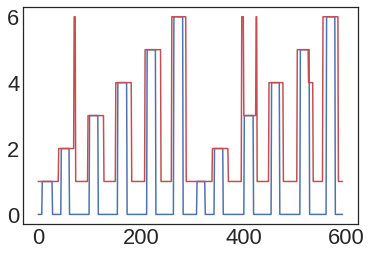

0.9434158864391423

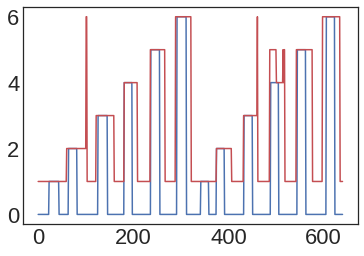